# LED Pulse Lifetimes vs Temperature
## Import the Libraries

In [1]:
import sys,os,time 
import h5py

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

sys.path.append('/home/nexus-admin/NEXUS_RF/BackendTools')
# import PyMKID_USRP_functions as PUf
# import PyMKID_resolution_functions as Prf
import MB_equations as MBe
import TimestreamHelperFunctions as Thf
import OptFilterTools as oft
import PyMKID_USRP_functions as PUf
import PyMKID_resolution_functions as Prf

## Define the MB Parameters

In [2]:
## MB Results come from fitting a temperature scan at a specified RF power
use_nexus_MBvals = False

if use_nexus_MBvals:
    ## As measured in NEXUS
    MB_fit_vals = np.array([4.24216+9.75e-6, 
                            0.177  ,
                            0.0125 ,
                            4.1e7  ]) ## [ F0 [GHz] , Delta [meV] , alpha , Qi0 ]
else:
    ## As measured on Caltech sister device (https://arxiv.org/pdf/2111.08064.pdf)
    MB_fit_vals = np.array([4.24201000, 
                            0.184     ,
                            0.03801   ,
                            4.05538e5 ]) ## [ F0 [GHz] , Delta [meV] , alpha , Qi0 ]
    
## How much attenuation is in the lines before the chip
line_atten_dB = 56.5

## Define the PSD Parameters

In [3]:
## PSD hi and lo frequency limits
chunk_up_to      = 1e1
decimate_down_to = 5e4

## Transient period at front of timestream
blank_fraction = 0.1

## Removal decimation for cleaning (more == better high-F cleaning)
removal_dec    = 10

## Pull the Data File Index Information

In [4]:
V_led    = 4.00

day_str  = "20230216"

datapath = '/data/USRP_Laser_TempScan_Data'
idx_name = "_run_temperatures.csv"

data_idx = pd.read_csv( os.path.join(datapath,day_str,day_str+idx_name), header=None, names=["series","sp K","Ti mK","Tf mK"], skiprows=12 )
data_idx #= data_idx.loc[12:]

,series,sp K,Ti mK,Tf mK
0,20230216_071116,0.350,350.1910,350.2120
1,20230216_072700,0.325,325.0070,324.9740
2,20230216_074409,0.300,300.2170,300.1100
3,20230216_080018,0.275,275.0680,275.0700
4,20230216_081556,0.250,249.9580,250.1490
5,20230216_083136,0.225,224.7530,224.9740
6,20230216_084716,0.200,199.8420,200.0510
7,20230216_090256,0.175,174.9210,174.9870
8,20230216_091908,0.150,149.9440,150.0010
9,20230216_101733,0.125,125.0450,125.0270


In [5]:
t0 = 4.98 # 5.0
def exp_fit(t,A,tau):
    return A*np.exp(-t/tau)*np.heaviside(t-t0,0.5)

def dbl_exp_fit(t,A,a,tau1,tau2):
    return A*( np.exp(-t/tau1) + a*np.exp(-t/tau2) )*np.heaviside(t-t0,0.5)

def prompt_shape(t,a0,tau0,kappa0):
    prompt = a0 * (1 - np.exp(-(t-t0)/tau0)) * np.exp(-(t-t0)/kappa0) *np.heaviside(t-t0,0.5)
    return prompt

def pulse_shape(t,A0,aP,tauP,kappaP):
    delayed = aP * (1 - np.exp(-(t-t0)/tauP)) * np.exp(-(t-t0)/kappaP)
    return delayed*np.heaviside(t-t0,0.5)  + A0*prompt

a guess: 0.9999999999999999 true= 1.0


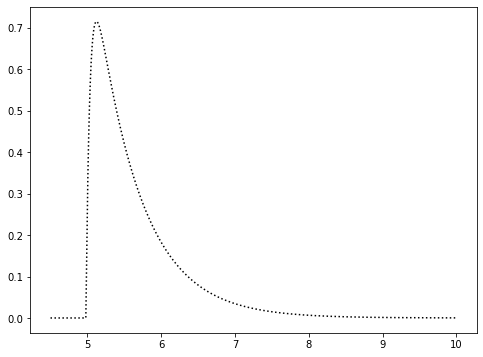

In [6]:
plt.figure("AA",figsize=(8,6))
vals = np.linspace(start=4.5,stop=10.0,num=1000)

tau = 0.06
kappa = 0.6
a_true = 1.0
pls_vals = prompt_shape(vals,a_true,tau,kappa)

ax1 = plt.gca()
ax1.plot( vals, pls_vals, 'k:')

pr_a = np.max(pls_vals) * np.exp((vals[np.argmax(pls_vals)]-t0)/kappa) / (1-np.exp(-(vals[np.argmax(pls_vals)]-t0)/tau))
print("a guess:",pr_a,"true=",a_true)

In [7]:
## Create a pandas df that we will write the average pulses to
f_avg_name = day_str+"_avg_pulses_Vled_"+str(V_led)+".h5"
avg_df = pd.DataFrame()
cplx_df = pd.DataFrame()
freq_df = pd.DataFrame()
diss_df = pd.DataFrame()

/home/nexus-admin/NEXUS_RF/BackendTools/TimestreamHelperFunctions.py:108: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  l_dict[kk] = md[k][kk].value


pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Laser_TempScan_Data/20230216/20230216_071116/USRP_Noise_20230216_071116_delta0.h5 because override=True!
found 3 pulses
computed electronics basis
cleaning...
saving clean_data to /data/USRP_Laser_TempScan_Data/20230216/20230216_071116/USRP_Noise_20230216_071116_delta0_cleaned.h5 because override=True!
Converting to resonator basis!
/data/USRP_Laser_TempScan_Data/20230216/20230216_071116/USRP_LaserOn_4.000V_20230216_071116.h5
plotting pulse file: /data/USRP_Laser_TempScan_Data/20230216/20230216_071116/USRP_LaserOn_4.000V_20230216_071116.h5
using VNA file:      /data/USRP_Laser_TempScan_Data/20230216/20230216_071116/USRP_VNA_20230216_071116.h5
using noise file:    /data/USRP_Laser_TempScan_Data/20230216/20230216_071116/USRP_Noise_20230216_071116_delta0.h5
H5 cuts file exists, not overwriting...
/data/USRP_Laser_TempScan_Data/20230216/20230216_071116/USRP_LaserOn_4.000V_20

<ipython-input-5-c56452f56de8>:9: RuntimeWarning: overflow encountered in exp
  prompt = a0 * (1 - np.exp(-(t-t0)/tau0)) * np.exp(-(t-t0)/kappa0) *np.heaviside(t-t0,0.5)
<ipython-input-5-c56452f56de8>:9: RuntimeWarning: overflow encountered in multiply
  prompt = a0 * (1 - np.exp(-(t-t0)/tau0)) * np.exp(-(t-t0)/kappa0) *np.heaviside(t-t0,0.5)
<ipython-input-5-c56452f56de8>:9: RuntimeWarning: invalid value encountered in multiply
  prompt = a0 * (1 - np.exp(-(t-t0)/tau0)) * np.exp(-(t-t0)/kappa0) *np.heaviside(t-t0,0.5)
/home/nexus-admin/NEXUS_RF/BackendTools/TimestreamHelperFunctions.py:108: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  l_dict[kk] = md[k][kk].value


pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Laser_TempScan_Data/20230216/20230216_072700/USRP_Noise_20230216_072700_delta0.h5 because override=True!
found 5 pulses
computed electronics basis
cleaning...
saving clean_data to /data/USRP_Laser_TempScan_Data/20230216/20230216_072700/USRP_Noise_20230216_072700_delta0_cleaned.h5 because override=True!
Converting to resonator basis!
/data/USRP_Laser_TempScan_Data/20230216/20230216_072700/USRP_LaserOn_4.000V_20230216_072700.h5
plotting pulse file: /data/USRP_Laser_TempScan_Data/20230216/20230216_072700/USRP_LaserOn_4.000V_20230216_072700.h5
using VNA file:      /data/USRP_Laser_TempScan_Data/20230216/20230216_072700/USRP_VNA_20230216_072700.h5
using noise file:    /data/USRP_Laser_TempScan_Data/20230216/20230216_072700/USRP_Noise_20230216_072700_delta0.h5
H5 cuts file exists, not overwriting...
/data/USRP_Laser_TempScan_Data/20230216/20230216_072700/USRP_LaserOn_4.000V_20

<ipython-input-5-c56452f56de8>:9: RuntimeWarning: overflow encountered in exp
  prompt = a0 * (1 - np.exp(-(t-t0)/tau0)) * np.exp(-(t-t0)/kappa0) *np.heaviside(t-t0,0.5)
<ipython-input-5-c56452f56de8>:9: RuntimeWarning: overflow encountered in multiply
  prompt = a0 * (1 - np.exp(-(t-t0)/tau0)) * np.exp(-(t-t0)/kappa0) *np.heaviside(t-t0,0.5)
<ipython-input-5-c56452f56de8>:9: RuntimeWarning: invalid value encountered in multiply
  prompt = a0 * (1 - np.exp(-(t-t0)/tau0)) * np.exp(-(t-t0)/kappa0) *np.heaviside(t-t0,0.5)
/home/nexus-admin/NEXUS_RF/BackendTools/TimestreamHelperFunctions.py:108: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  l_dict[kk] = md[k][kk].value


pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Laser_TempScan_Data/20230216/20230216_074409/USRP_Noise_20230216_074409_delta0.h5 because override=True!
found 5 pulses
computed electronics basis
cleaning...
saving clean_data to /data/USRP_Laser_TempScan_Data/20230216/20230216_074409/USRP_Noise_20230216_074409_delta0_cleaned.h5 because override=True!
Converting to resonator basis!
/data/USRP_Laser_TempScan_Data/20230216/20230216_074409/USRP_LaserOn_4.000V_20230216_074409.h5
plotting pulse file: /data/USRP_Laser_TempScan_Data/20230216/20230216_074409/USRP_LaserOn_4.000V_20230216_074409.h5
using VNA file:      /data/USRP_Laser_TempScan_Data/20230216/20230216_074409/USRP_VNA_20230216_074409.h5
using noise file:    /data/USRP_Laser_TempScan_Data/20230216/20230216_074409/USRP_Noise_20230216_074409_delta0.h5
H5 cuts file exists, not overwriting...
/data/USRP_Laser_TempScan_Data/20230216/20230216_074409/USRP_LaserOn_4.000V_20

<ipython-input-5-c56452f56de8>:9: RuntimeWarning: overflow encountered in exp
  prompt = a0 * (1 - np.exp(-(t-t0)/tau0)) * np.exp(-(t-t0)/kappa0) *np.heaviside(t-t0,0.5)
<ipython-input-5-c56452f56de8>:9: RuntimeWarning: overflow encountered in multiply
  prompt = a0 * (1 - np.exp(-(t-t0)/tau0)) * np.exp(-(t-t0)/kappa0) *np.heaviside(t-t0,0.5)
<ipython-input-5-c56452f56de8>:9: RuntimeWarning: invalid value encountered in multiply
  prompt = a0 * (1 - np.exp(-(t-t0)/tau0)) * np.exp(-(t-t0)/kappa0) *np.heaviside(t-t0,0.5)
/home/nexus-admin/NEXUS_RF/BackendTools/TimestreamHelperFunctions.py:108: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  l_dict[kk] = md[k][kk].value


pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Laser_TempScan_Data/20230216/20230216_080018/USRP_Noise_20230216_080018_delta0.h5 because override=True!
found 1 pulses
computed electronics basis
cleaning...
saving clean_data to /data/USRP_Laser_TempScan_Data/20230216/20230216_080018/USRP_Noise_20230216_080018_delta0_cleaned.h5 because override=True!
Converting to resonator basis!
/data/USRP_Laser_TempScan_Data/20230216/20230216_080018/USRP_LaserOn_4.000V_20230216_080018.h5
plotting pulse file: /data/USRP_Laser_TempScan_Data/20230216/20230216_080018/USRP_LaserOn_4.000V_20230216_080018.h5
using VNA file:      /data/USRP_Laser_TempScan_Data/20230216/20230216_080018/USRP_VNA_20230216_080018.h5
using noise file:    /data/USRP_Laser_TempScan_Data/20230216/20230216_080018/USRP_Noise_20230216_080018_delta0.h5
H5 cuts file exists, not overwriting...
/data/USRP_Laser_TempScan_Data/20230216/20230216_080018/USRP_LaserOn_4.000V_20

<ipython-input-5-c56452f56de8>:9: RuntimeWarning: overflow encountered in exp
  prompt = a0 * (1 - np.exp(-(t-t0)/tau0)) * np.exp(-(t-t0)/kappa0) *np.heaviside(t-t0,0.5)
<ipython-input-5-c56452f56de8>:9: RuntimeWarning: overflow encountered in multiply
  prompt = a0 * (1 - np.exp(-(t-t0)/tau0)) * np.exp(-(t-t0)/kappa0) *np.heaviside(t-t0,0.5)
<ipython-input-5-c56452f56de8>:9: RuntimeWarning: invalid value encountered in multiply
  prompt = a0 * (1 - np.exp(-(t-t0)/tau0)) * np.exp(-(t-t0)/kappa0) *np.heaviside(t-t0,0.5)
/home/nexus-admin/NEXUS_RF/BackendTools/TimestreamHelperFunctions.py:108: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  l_dict[kk] = md[k][kk].value


pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Laser_TempScan_Data/20230216/20230216_081556/USRP_Noise_20230216_081556_delta0.h5 because override=True!
found 3 pulses
computed electronics basis
cleaning...
saving clean_data to /data/USRP_Laser_TempScan_Data/20230216/20230216_081556/USRP_Noise_20230216_081556_delta0_cleaned.h5 because override=True!
Converting to resonator basis!
/data/USRP_Laser_TempScan_Data/20230216/20230216_081556/USRP_LaserOn_4.000V_20230216_081556.h5
plotting pulse file: /data/USRP_Laser_TempScan_Data/20230216/20230216_081556/USRP_LaserOn_4.000V_20230216_081556.h5
using VNA file:      /data/USRP_Laser_TempScan_Data/20230216/20230216_081556/USRP_VNA_20230216_081556.h5
using noise file:    /data/USRP_Laser_TempScan_Data/20230216/20230216_081556/USRP_Noise_20230216_081556_delta0.h5
H5 cuts file exists, not overwriting...
/data/USRP_Laser_TempScan_Data/20230216/20230216_081556/USRP_LaserOn_4.000V_20

<ipython-input-5-c56452f56de8>:9: RuntimeWarning: overflow encountered in exp
  prompt = a0 * (1 - np.exp(-(t-t0)/tau0)) * np.exp(-(t-t0)/kappa0) *np.heaviside(t-t0,0.5)
<ipython-input-5-c56452f56de8>:9: RuntimeWarning: overflow encountered in multiply
  prompt = a0 * (1 - np.exp(-(t-t0)/tau0)) * np.exp(-(t-t0)/kappa0) *np.heaviside(t-t0,0.5)
<ipython-input-5-c56452f56de8>:9: RuntimeWarning: invalid value encountered in multiply
  prompt = a0 * (1 - np.exp(-(t-t0)/tau0)) * np.exp(-(t-t0)/kappa0) *np.heaviside(t-t0,0.5)
/home/nexus-admin/NEXUS_RF/BackendTools/TimestreamHelperFunctions.py:108: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  l_dict[kk] = md[k][kk].value


pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Laser_TempScan_Data/20230216/20230216_083136/USRP_Noise_20230216_083136_delta0.h5 because override=True!
found 7 pulses
computed electronics basis
cleaning...
saving clean_data to /data/USRP_Laser_TempScan_Data/20230216/20230216_083136/USRP_Noise_20230216_083136_delta0_cleaned.h5 because override=True!
Converting to resonator basis!
/data/USRP_Laser_TempScan_Data/20230216/20230216_083136/USRP_LaserOn_4.000V_20230216_083136.h5
plotting pulse file: /data/USRP_Laser_TempScan_Data/20230216/20230216_083136/USRP_LaserOn_4.000V_20230216_083136.h5
using VNA file:      /data/USRP_Laser_TempScan_Data/20230216/20230216_083136/USRP_VNA_20230216_083136.h5
using noise file:    /data/USRP_Laser_TempScan_Data/20230216/20230216_083136/USRP_Noise_20230216_083136_delta0.h5
H5 cuts file exists, not overwriting...
/data/USRP_Laser_TempScan_Data/20230216/20230216_083136/USRP_LaserOn_4.000V_20

<ipython-input-5-c56452f56de8>:9: RuntimeWarning: overflow encountered in exp
  prompt = a0 * (1 - np.exp(-(t-t0)/tau0)) * np.exp(-(t-t0)/kappa0) *np.heaviside(t-t0,0.5)
<ipython-input-5-c56452f56de8>:9: RuntimeWarning: invalid value encountered in multiply
  prompt = a0 * (1 - np.exp(-(t-t0)/tau0)) * np.exp(-(t-t0)/kappa0) *np.heaviside(t-t0,0.5)
/home/nexus-admin/NEXUS_RF/BackendTools/TimestreamHelperFunctions.py:108: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  l_dict[kk] = md[k][kk].value


pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Laser_TempScan_Data/20230216/20230216_084716/USRP_Noise_20230216_084716_delta0.h5 because override=True!
found 11 pulses
computed electronics basis
cleaning...
saving clean_data to /data/USRP_Laser_TempScan_Data/20230216/20230216_084716/USRP_Noise_20230216_084716_delta0_cleaned.h5 because override=True!
Converting to resonator basis!
/data/USRP_Laser_TempScan_Data/20230216/20230216_084716/USRP_LaserOn_4.000V_20230216_084716.h5
plotting pulse file: /data/USRP_Laser_TempScan_Data/20230216/20230216_084716/USRP_LaserOn_4.000V_20230216_084716.h5
using VNA file:      /data/USRP_Laser_TempScan_Data/20230216/20230216_084716/USRP_VNA_20230216_084716.h5
using noise file:    /data/USRP_Laser_TempScan_Data/20230216/20230216_084716/USRP_Noise_20230216_084716_delta0.h5
H5 cuts file exists, not overwriting...
/data/USRP_Laser_TempScan_Data/20230216/20230216_084716/USRP_LaserOn_4.000V_2

<ipython-input-5-c56452f56de8>:9: RuntimeWarning: overflow encountered in exp
  prompt = a0 * (1 - np.exp(-(t-t0)/tau0)) * np.exp(-(t-t0)/kappa0) *np.heaviside(t-t0,0.5)
<ipython-input-5-c56452f56de8>:9: RuntimeWarning: invalid value encountered in multiply
  prompt = a0 * (1 - np.exp(-(t-t0)/tau0)) * np.exp(-(t-t0)/kappa0) *np.heaviside(t-t0,0.5)
/home/nexus-admin/NEXUS_RF/BackendTools/TimestreamHelperFunctions.py:108: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  l_dict[kk] = md[k][kk].value


pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Laser_TempScan_Data/20230216/20230216_090256/USRP_Noise_20230216_090256_delta0.h5 because override=True!
found 5 pulses
computed electronics basis
cleaning...
saving clean_data to /data/USRP_Laser_TempScan_Data/20230216/20230216_090256/USRP_Noise_20230216_090256_delta0_cleaned.h5 because override=True!
Converting to resonator basis!
/data/USRP_Laser_TempScan_Data/20230216/20230216_090256/USRP_LaserOn_4.000V_20230216_090256.h5
plotting pulse file: /data/USRP_Laser_TempScan_Data/20230216/20230216_090256/USRP_LaserOn_4.000V_20230216_090256.h5
using VNA file:      /data/USRP_Laser_TempScan_Data/20230216/20230216_090256/USRP_VNA_20230216_090256.h5
using noise file:    /data/USRP_Laser_TempScan_Data/20230216/20230216_090256/USRP_Noise_20230216_090256_delta0.h5
H5 cuts file exists, not overwriting...
/data/USRP_Laser_TempScan_Data/20230216/20230216_090256/USRP_LaserOn_4.000V_20

<ipython-input-5-c56452f56de8>:9: RuntimeWarning: overflow encountered in exp
  prompt = a0 * (1 - np.exp(-(t-t0)/tau0)) * np.exp(-(t-t0)/kappa0) *np.heaviside(t-t0,0.5)
<ipython-input-5-c56452f56de8>:9: RuntimeWarning: invalid value encountered in multiply
  prompt = a0 * (1 - np.exp(-(t-t0)/tau0)) * np.exp(-(t-t0)/kappa0) *np.heaviside(t-t0,0.5)
/home/nexus-admin/NEXUS_RF/BackendTools/PyMKID_USRP_functions.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  axV = plt.figure().gca()
/home/nexus-admin/NEXUS_RF/BackendTools/TimestreamHelperFunctions.py:108: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  l_dict[kk] = md[k][kk].value


pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Laser_TempScan_Data/20230216/20230216_091908/USRP_Noise_20230216_091908_delta0.h5 because override=True!
found 6 pulses
computed electronics basis
cleaning...
saving clean_data to /data/USRP_Laser_TempScan_Data/20230216/20230216_091908/USRP_Noise_20230216_091908_delta0_cleaned.h5 because override=True!
Converting to resonator basis!
/data/USRP_Laser_TempScan_Data/20230216/20230216_091908/USRP_LaserOn_4.000V_20230216_091908.h5
plotting pulse file: /data/USRP_Laser_TempScan_Data/20230216/20230216_091908/USRP_LaserOn_4.000V_20230216_091908.h5
using VNA file:      /data/USRP_Laser_TempScan_Data/20230216/20230216_091908/USRP_VNA_20230216_091908.h5
using noise file:    /data/USRP_Laser_TempScan_Data/20230216/20230216_091908/USRP_Noise_20230216_091908_delta0.h5
H5 cuts file exists, not overwriting...
/data/USRP_Laser_TempScan_Data/20230216/20230216_091908/USRP_LaserOn_4.000V_20

<ipython-input-5-c56452f56de8>:9: RuntimeWarning: overflow encountered in exp
  prompt = a0 * (1 - np.exp(-(t-t0)/tau0)) * np.exp(-(t-t0)/kappa0) *np.heaviside(t-t0,0.5)
<ipython-input-5-c56452f56de8>:9: RuntimeWarning: invalid value encountered in multiply
  prompt = a0 * (1 - np.exp(-(t-t0)/tau0)) * np.exp(-(t-t0)/kappa0) *np.heaviside(t-t0,0.5)
/home/nexus-admin/NEXUS_RF/BackendTools/TimestreamHelperFunctions.py:108: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  l_dict[kk] = md[k][kk].value


pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Laser_TempScan_Data/20230216/20230216_101733/USRP_Noise_20230216_101733_delta0.h5 because override=True!
found 4 pulses
computed electronics basis
cleaning...
saving clean_data to /data/USRP_Laser_TempScan_Data/20230216/20230216_101733/USRP_Noise_20230216_101733_delta0_cleaned.h5 because override=True!
Converting to resonator basis!
/data/USRP_Laser_TempScan_Data/20230216/20230216_101733/USRP_LaserOn_4.000V_20230216_101733.h5
plotting pulse file: /data/USRP_Laser_TempScan_Data/20230216/20230216_101733/USRP_LaserOn_4.000V_20230216_101733.h5
using VNA file:      /data/USRP_Laser_TempScan_Data/20230216/20230216_101733/USRP_VNA_20230216_101733.h5
using noise file:    /data/USRP_Laser_TempScan_Data/20230216/20230216_101733/USRP_Noise_20230216_101733_delta0.h5
H5 cuts file exists, not overwriting...
/data/USRP_Laser_TempScan_Data/20230216/20230216_101733/USRP_LaserOn_4.000V_20

<ipython-input-5-c56452f56de8>:9: RuntimeWarning: overflow encountered in exp
  prompt = a0 * (1 - np.exp(-(t-t0)/tau0)) * np.exp(-(t-t0)/kappa0) *np.heaviside(t-t0,0.5)
<ipython-input-5-c56452f56de8>:9: RuntimeWarning: invalid value encountered in multiply
  prompt = a0 * (1 - np.exp(-(t-t0)/tau0)) * np.exp(-(t-t0)/kappa0) *np.heaviside(t-t0,0.5)
/home/nexus-admin/NEXUS_RF/BackendTools/TimestreamHelperFunctions.py:108: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  l_dict[kk] = md[k][kk].value


pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Laser_TempScan_Data/20230216/20230216_104659/USRP_Noise_20230216_104659_delta0.h5 because override=True!
found 0 pulses
computed electronics basis
cleaning...
saving clean_data to /data/USRP_Laser_TempScan_Data/20230216/20230216_104659/USRP_Noise_20230216_104659_delta0_cleaned.h5 because override=True!
Converting to resonator basis!
/data/USRP_Laser_TempScan_Data/20230216/20230216_104659/USRP_LaserOn_4.000V_20230216_104659.h5
plotting pulse file: /data/USRP_Laser_TempScan_Data/20230216/20230216_104659/USRP_LaserOn_4.000V_20230216_104659.h5
using VNA file:      /data/USRP_Laser_TempScan_Data/20230216/20230216_104659/USRP_VNA_20230216_104659.h5
using noise file:    /data/USRP_Laser_TempScan_Data/20230216/20230216_104659/USRP_Noise_20230216_104659_delta0.h5
H5 cuts file exists, not overwriting...
/data/USRP_Laser_TempScan_Data/20230216/20230216_104659/USRP_LaserOn_4.000V_20

<ipython-input-5-c56452f56de8>:9: RuntimeWarning: overflow encountered in exp
  prompt = a0 * (1 - np.exp(-(t-t0)/tau0)) * np.exp(-(t-t0)/kappa0) *np.heaviside(t-t0,0.5)
<ipython-input-5-c56452f56de8>:9: RuntimeWarning: invalid value encountered in multiply
  prompt = a0 * (1 - np.exp(-(t-t0)/tau0)) * np.exp(-(t-t0)/kappa0) *np.heaviside(t-t0,0.5)
/home/nexus-admin/NEXUS_RF/BackendTools/TimestreamHelperFunctions.py:108: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  l_dict[kk] = md[k][kk].value


pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Laser_TempScan_Data/20230216/20230216_110206/USRP_Noise_20230216_110206_delta0.h5 because override=True!
found 1 pulses
computed electronics basis
cleaning...
saving clean_data to /data/USRP_Laser_TempScan_Data/20230216/20230216_110206/USRP_Noise_20230216_110206_delta0_cleaned.h5 because override=True!
Converting to resonator basis!
/data/USRP_Laser_TempScan_Data/20230216/20230216_110206/USRP_LaserOn_4.000V_20230216_110206.h5
plotting pulse file: /data/USRP_Laser_TempScan_Data/20230216/20230216_110206/USRP_LaserOn_4.000V_20230216_110206.h5
using VNA file:      /data/USRP_Laser_TempScan_Data/20230216/20230216_110206/USRP_VNA_20230216_110206.h5
using noise file:    /data/USRP_Laser_TempScan_Data/20230216/20230216_110206/USRP_Noise_20230216_110206_delta0.h5
H5 cuts file exists, not overwriting...
/data/USRP_Laser_TempScan_Data/20230216/20230216_110206/USRP_LaserOn_4.000V_20

<ipython-input-5-c56452f56de8>:9: RuntimeWarning: overflow encountered in exp
  prompt = a0 * (1 - np.exp(-(t-t0)/tau0)) * np.exp(-(t-t0)/kappa0) *np.heaviside(t-t0,0.5)
<ipython-input-5-c56452f56de8>:9: RuntimeWarning: invalid value encountered in multiply
  prompt = a0 * (1 - np.exp(-(t-t0)/tau0)) * np.exp(-(t-t0)/kappa0) *np.heaviside(t-t0,0.5)
/home/nexus-admin/NEXUS_RF/BackendTools/TimestreamHelperFunctions.py:108: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  l_dict[kk] = md[k][kk].value


pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to /data/USRP_Laser_TempScan_Data/20230216/20230216_112219/USRP_Noise_20230216_112219_delta0.h5 because override=True!
found 0 pulses
computed electronics basis
cleaning...
saving clean_data to /data/USRP_Laser_TempScan_Data/20230216/20230216_112219/USRP_Noise_20230216_112219_delta0_cleaned.h5 because override=True!
Converting to resonator basis!
/data/USRP_Laser_TempScan_Data/20230216/20230216_112219/USRP_LaserOn_4.000V_20230216_112219.h5
plotting pulse file: /data/USRP_Laser_TempScan_Data/20230216/20230216_112219/USRP_LaserOn_4.000V_20230216_112219.h5
using VNA file:      /data/USRP_Laser_TempScan_Data/20230216/20230216_112219/USRP_VNA_20230216_112219.h5
using noise file:    /data/USRP_Laser_TempScan_Data/20230216/20230216_112219/USRP_Noise_20230216_112219_delta0.h5
H5 cuts file exists, not overwriting...
/data/USRP_Laser_TempScan_Data/20230216/20230216_112219/USRP_LaserOn_4.000V_20

<ipython-input-5-c56452f56de8>:9: RuntimeWarning: overflow encountered in exp
  prompt = a0 * (1 - np.exp(-(t-t0)/tau0)) * np.exp(-(t-t0)/kappa0) *np.heaviside(t-t0,0.5)
<ipython-input-5-c56452f56de8>:9: RuntimeWarning: invalid value encountered in multiply
  prompt = a0 * (1 - np.exp(-(t-t0)/tau0)) * np.exp(-(t-t0)/kappa0) *np.heaviside(t-t0,0.5)


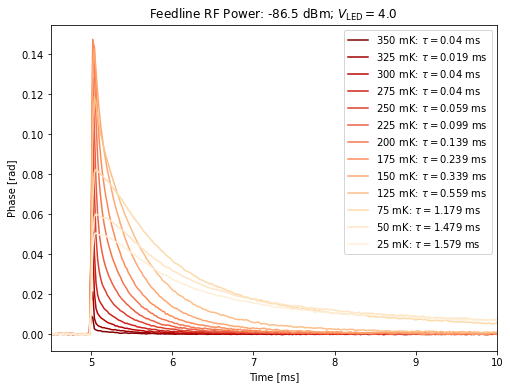

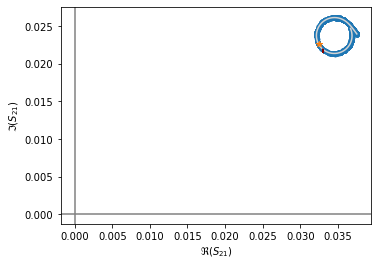

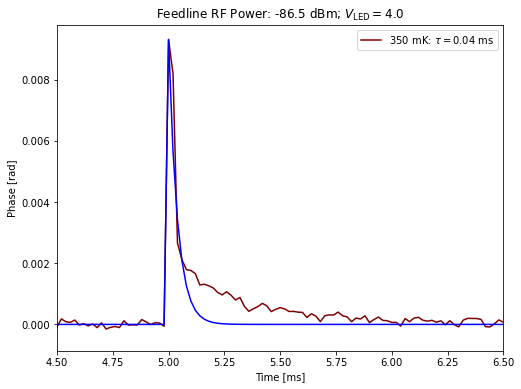

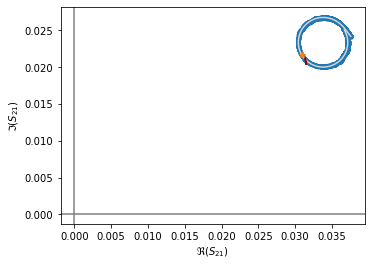

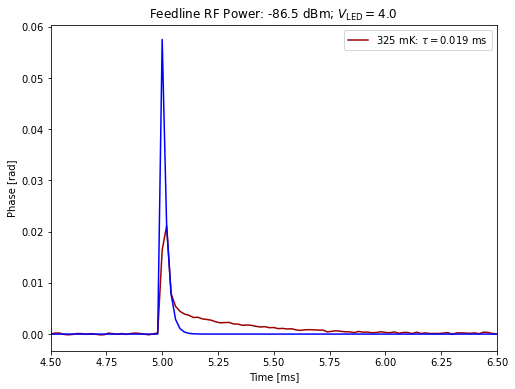

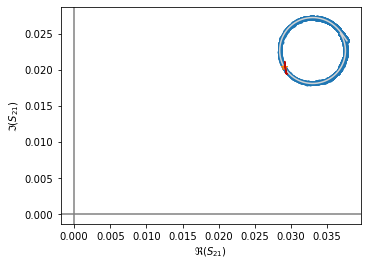

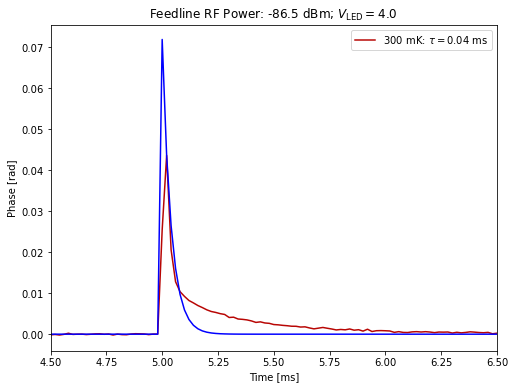

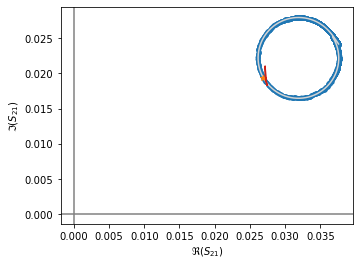

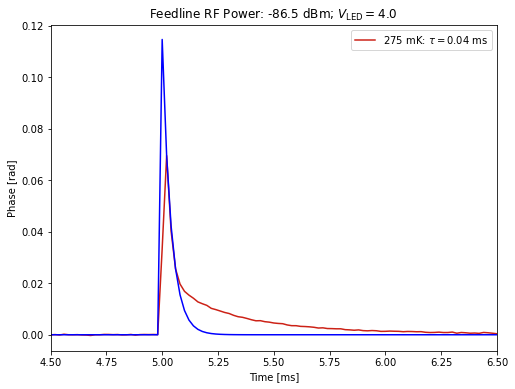

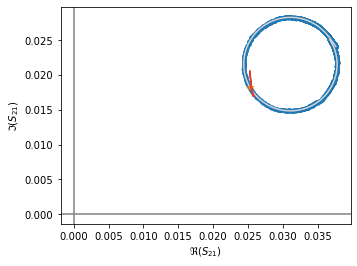

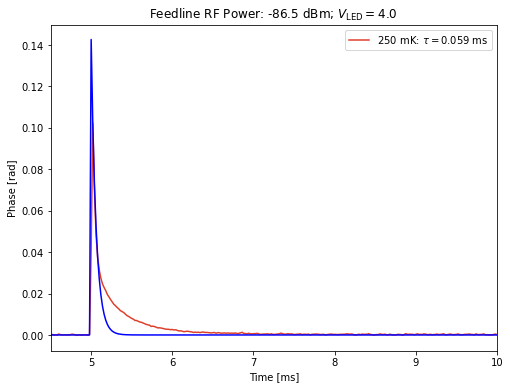

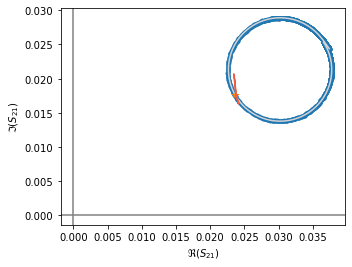

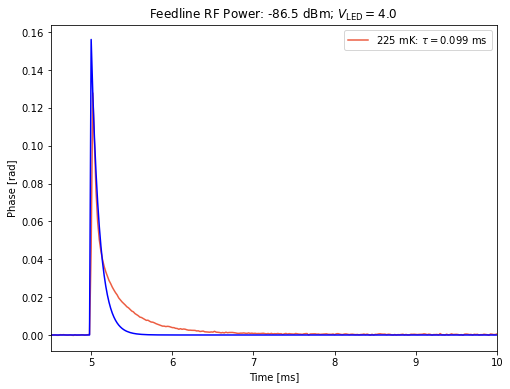

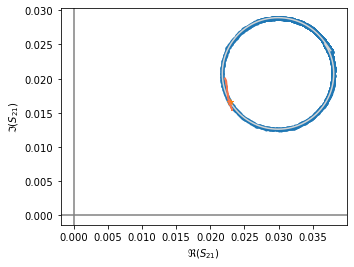

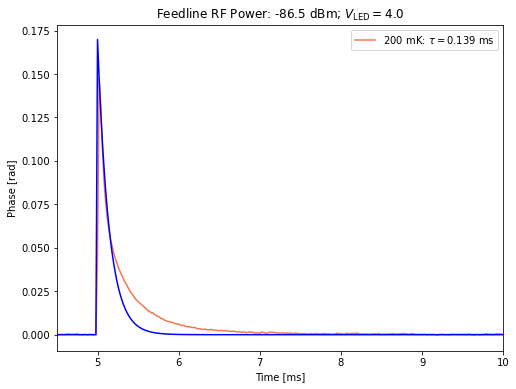

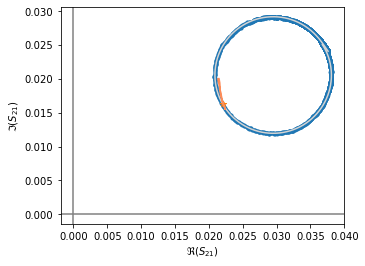

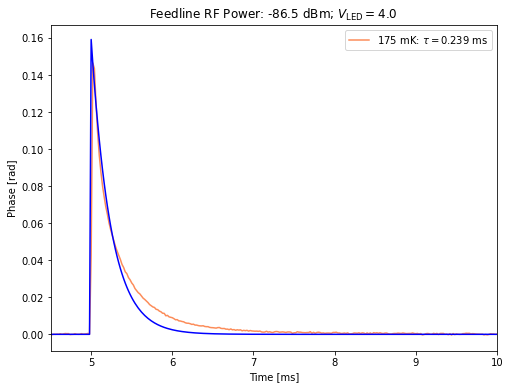

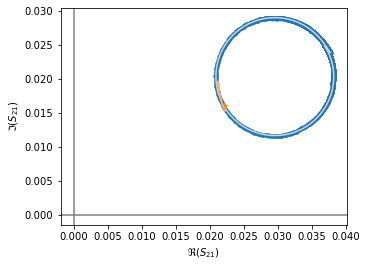

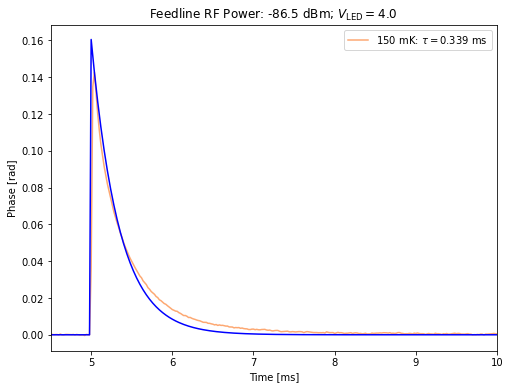

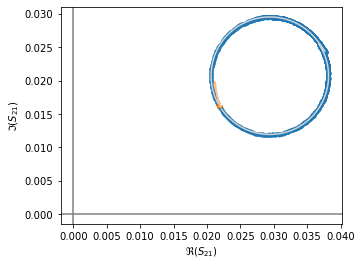

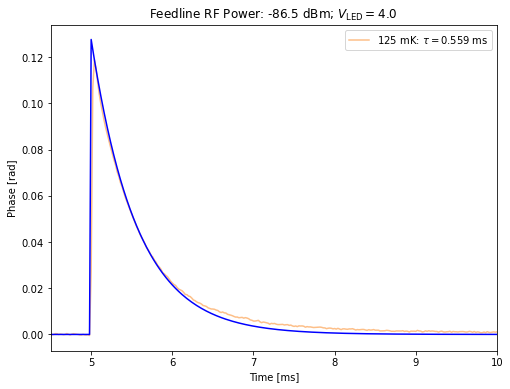

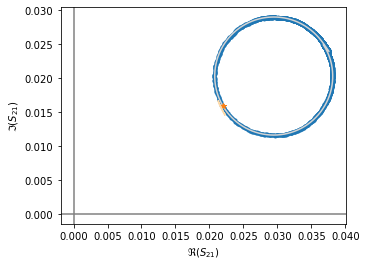

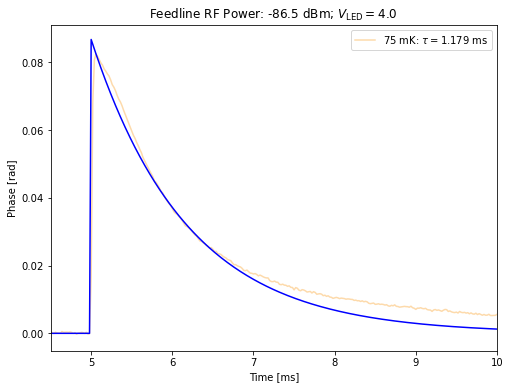

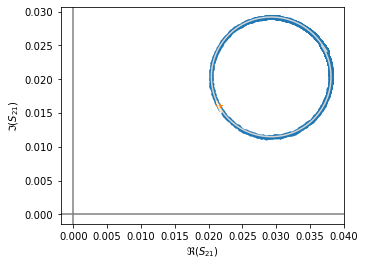

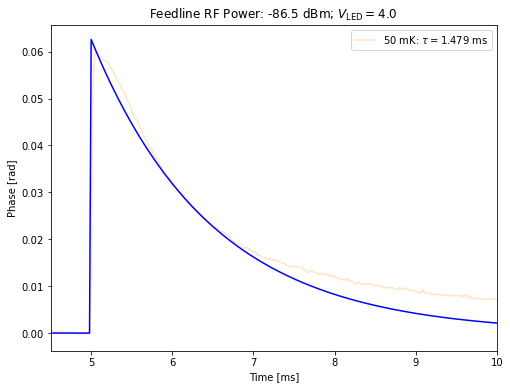

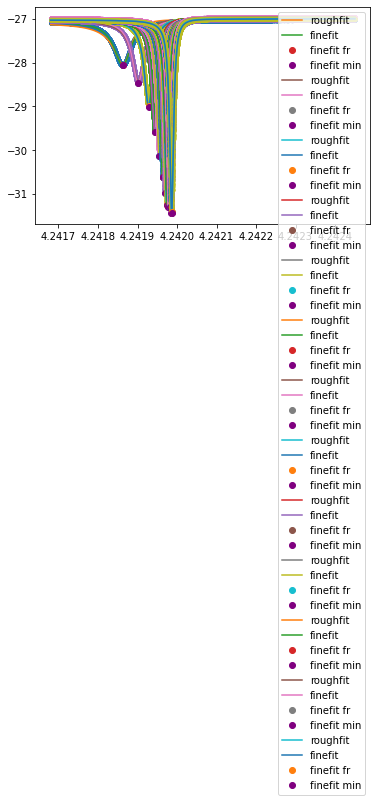

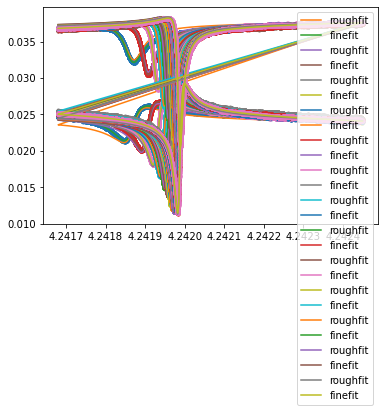

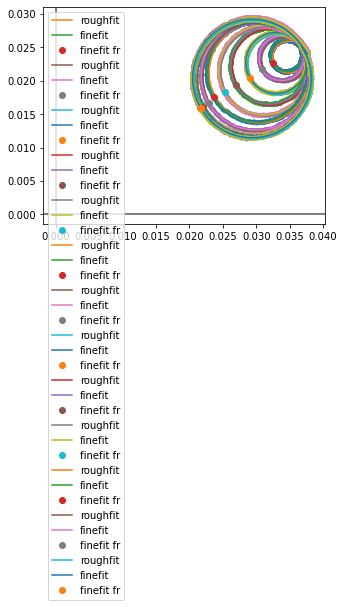

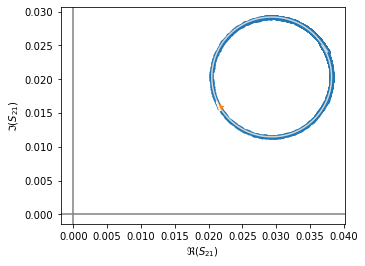

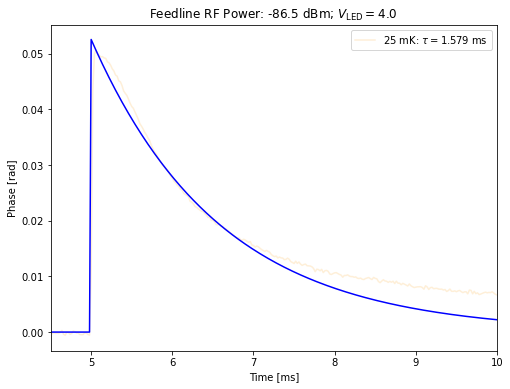

In [8]:
# %matplotlib notebook
plt.figure("A",figsize=(8,6))
ax0 = plt.gca()
ax0.set_xlabel("Time [ms]")
ax0.set_ylabel("Phase [rad]")
ax0.set_title("Feedline RF Power: "+str(-30-line_atten_dB)+r" dBm; $V_\mathrm{LED}=$"+str(V_led))
cmap = plt.get_cmap('OrRd')
xlims = [4.5, 10.0]

N_temps = len(data_idx)-1 ## Something wrong with the 15 mK run

lifetimes  = np.zeros(N_temps)
amplitudes = np.zeros(N_temps)
temps_mK   = np.zeros(N_temps)

for i in np.arange(N_temps):
    ## Pull the series information
    series = data_idx["series"].loc[i]
    T_sp_K = data_idx["sp K"].loc[i]
    temps_mK[i] = T_sp_K*1e3
    
    ## Skip a bad file
    if np.abs(T_sp_K - 0.100) < 0.001:
        continue
    
    ## Get the color for this temperature
    color=cmap( T_sp_K / np.max(data_idx["sp K"]) )
    
    ## Get the file lists
    sum_file, dly_file, vna_file, nse_files, led_files = Thf.GetFiles(series, 
                                                        base_path=datapath,
                                                        sep_noise_laser=True,
                                                        verbose=False)
    
    ## Plot the VNA data to make sure we're on the right tone
    PUf.vna_file_fit(vna_file,[4.24218],show=True)
    VNA_f, VNA_z = PUf.read_vna(vna_file)
    
    ## Parse the metadata
    voltages, p_params, charFs, charZs = oft.parse_metadata(sum_file, 
                                                        blank_fraction=blank_fraction, 
                                                        verbose=False)
    
    ## Clean the noise file
    powers, PSDs, res, timestreams = Thf.CleanPSDs(nse_files[0], vna_file, 
        PSD_lo_f=chunk_up_to, 
        PSD_hi_f=decimate_down_to, 
        rem_dec=removal_dec,
        f_transient=blank_fraction, 
        charFs=charFs.real, 
        charZs=charZs,
        verbose=False,
        show_plots=False)
    
    ## Find the right LED file
    led_file = led_files[np.argmin(np.abs(voltages-V_led))]
    print(led_file)
    
    ## Look at the pulse windows
    mean_dict, sdev_dict, maxv_dict = oft.plot_all_pulse_windows([led_file], nse_files[0], vna_file, p_params, 
        decimate_down_to=None, pulse_cln_dec=4, show_plots=False)
    
    ## Define and apply the cuts, just use default for now
    cut_df       = oft.define_default_cuts([led_file], mean_dict, sdev_dict, maxv_dict)
    bad_pls_idxs = oft.get_all_bad_pulse_idxs([led_file], cut_df, mean_dict, sdev_dict, maxv_dict)
    
    ## Clean the pulse windows
    oft.clean_pulse_windows(led_file, nse_files[0], vna_file, p_params, bad_pls_idxs, decimate_down_to=None, pulse_cln_dec=4, show_plots=False)

    ## Get the average pulse shape
    avg, sr = oft.get_average_pulse(led_file, vna_file, p_params, bad_pls_idxs, extra_decimation=1, show_plots=False, verbose=False)
    
    ax2 = plt.gca()
    ax2.set_xlabel(r"$\Re (S_{21})$")
    ax2.set_ylabel(r"$\Im (S_{21})$")
    ax2.plot( avg.real, avg.imag, label=str(int(data_idx["sp K"].loc[i]*1e3))+r" mK" , color=color)
    
    frequency, dissipation, ideal, resonator = Prf.resonator_basis(avg,
        VNA_f=VNA_f,
        VNA_z=VNA_z,
        readout_f=charFs[0].real,
        char_f=charFs.real, 
        char_z=charZs)
    
    ## Make names
    t_vals = np.arange(len(avg))/sr*1e3
    p_vals = np.angle(avg)-np.mean(np.angle(avg)[0:100])
    
    ## Save the average pulse
    if i==0:
        avg_df["time(ms)"] = t_vals
    avg_df[ str(int(data_idx["sp K"].loc[i]*1e3))] = p_vals
    cplx_df[str(int(data_idx["sp K"].loc[i]*1e3))] = avg
    freq_df[str(int(data_idx["sp K"].loc[i]*1e3))] = frequency
    diss_df[str(int(data_idx["sp K"].loc[i]*1e3))] = dissipation
    
    ## Make some guesses of the prompt parameters
    _p_max = np.max(p_vals)
    _t_max = t_vals[np.argmax(p_vals)]
    _p_1pe = _p_max*np.exp(-1)
    
    _ts_vals = t_vals[t_vals>t0][2:]
    _ps_vals = p_vals[t_vals>t0][2:]
    
    _t_1pe = _ts_vals[np.argmin(np.abs(_ps_vals-_p_1pe))]

    ## Turn those quantities into parameters
    tau_guess = _t_1pe - _t_max
    #tau_guess = t_vals[np.argmin(np.abs(p_vals-np.max(p_vals)*np.exp(-1)))]-t_vals[np.argmax(p_vals)]
    amp_guess = np.max(p_vals)*np.exp(t0/tau_guess)
    
    ## Initialize our guess array for fitting
    popt = [ amp_guess, np.max([0.01,tau_guess]) ]
#     popt, pcov = curve_fit(exp_fit,t_vals,p_vals,p0=popt)
#     print("==========>",popt)
    
    lifetimes[i]  = popt[1]
    amplitudes[i] = popt[0]
    
    prompt_t = 0.001
    prompt_a = np.max(p_vals) * np.exp((_t_max-t0)/popt[1]) / (1-np.exp(-(_t_max-t0)/prompt_t))
    
    ## Prepare to plot the prompt guess
    prompt_opt = [prompt_a,prompt_t,popt[1]]
    prompt = prompt_shape(t_vals,prompt_opt[0],prompt_opt[1],prompt_opt[2])
    
    ## Fit the prompt shape
    # prompt_opt, prompt_cov = curve_fit(prompt_shape,t_vals,p_vals,p0=prompt_opt)
    # prompt = prompt_shape(t_vals,prompt_opt[0],prompt_opt[1],prompt_opt[2])
    
#     ## Now fit the delayed+prompt shape
#     delay_t  = 0.01
#     delay_k  = popt[1]*10
#     delay_A  = 0.05
#     prompt_A = 0.05
    
#     ## Prepare to plot the pulse guess
#     pulse_opt = [prompt_A,delay_A,delay_t,delay_k]
#     pulse = pulse_shape(t_vals,pulse_opt[0],pulse_opt[1],pulse_opt[2],pulse_opt[3])
    
#     ## Fit the pulse shape
#     pulse_opt, pulse_cov = curve_fit(pulse_shape,t_vals,p_vals,p0=pulse_opt)
#     pulse = pulse_shape(t_vals,pulse_opt[0],pulse_opt[1],pulse_opt[2],pulse_opt[3])
    
    ## Add the average pulse to the to the plot of all temperatures
    ax0.plot( t_vals, p_vals, label=str(int(data_idx["sp K"].loc[i]*1e3))+r" mK: $\tau=$"+str(int(popt[1]*1e3)/1000.)+" ms" , color=color)
    # ax0.plot( t_vals, exp_fit(t_vals,popt[0],popt[1]), 'k--')
    
    ## Create a new plot for each individual temperature
    plt.figure(str(i)+"B",figsize=(8,6))
    ax1 = plt.gca()
    ax1.set_xlabel("Time [ms]")
    ax1.set_ylabel("Phase [rad]")
    ax1.set_title("Feedline RF Power: "+str(-30-line_atten_dB)+r" dBm; $V_\mathrm{LED}=$"+str(V_led))
    
    ## Plot the pulse
    ax1.plot( t_vals, p_vals, label=str(int(data_idx["sp K"].loc[i]*1e3))+r" mK: $\tau=$"+str(int(popt[1]*1e3)/1000.)+" ms" , color=color)
    ylims = ax1.get_ylim()
    
    ## Draw a simple exponential guess
    # ax1.plot( t_vals, exp_fit(t_vals,popt[0],popt[1]), 'k--')
    
    ## Draw a double exponential guess
    ax1.plot( t_vals, prompt, 'b-')
    # ax1.plot( t_vals, pulse, 'g--')
    
    ## Draw a curve for the sum of two exponentials
    # ax1.plot( t_vals, dbl_exp_fit(t_vals,popt[0]/(1+_a2_guess*np.exp(t0*(1/popt[1] - 1/_t2_guess))),_a2_guess,popt[1],_t2_guess), 'k:')
    
    ## Finalize the axes
    # ax1.set_ylim(ylims)
    ax1.set_xlim(xlims if popt[1]>0.05 else [xlims[0],6.5])#10.0])
    ax1.legend()
    
ax0.legend()
ax0.set_xlim(xlims)#10.0])

avg_df.to_hdf(f_avg_name,"data")
cplx_df.to_hdf(f_avg_name,"s21_cplx")
freq_df.to_hdf(f_avg_name,"freq")
diss_df.to_hdf(f_avg_name,"diss")

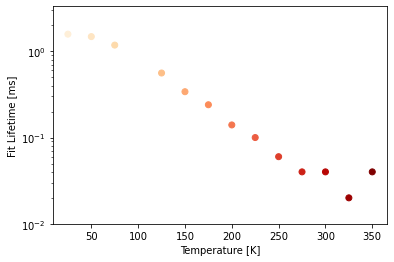

In [9]:
ax = plt.figure().gca()
ax.scatter(temps_mK,lifetimes,c=cmap( temps_mK / np.max(1e3*data_idx["sp K"]) ))
ax.set_xlabel("Temperature [K]")
ax.set_ylabel("Fit Lifetime [ms]")
if True:
    ylims = ax.get_ylim()
    ax.set_ylim([0.5*np.min(lifetimes[lifetimes>0]) , 2*ylims[1]])
    ax.set_yscale('log')

Text(0, 0.5, 'Fit Amplitude [rad]')

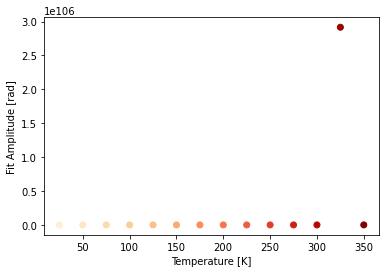

In [10]:
plt.scatter(temps_mK,amplitudes,c=cmap( temps_mK / np.max(1e3*data_idx["sp K"]) ))
plt.xlabel("Temperature [K]")
plt.ylabel("Fit Amplitude [rad]")